<a id="MLS"></a>
## Machine Learning Strategy

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf
import warnings
import random
from sklearn.metrics import accuracy_score

In [2]:
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.tree import DecisionTreeRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR

# Bagging
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

# Boosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.neural_network import MLPRegressor

In [3]:
model=[LinearRegression(),Lasso(),ElasticNet(),DecisionTreeRegressor(),KNeighborsRegressor(),
       SVR(),ExtraTreesRegressor(),RandomForestRegressor(),GradientBoostingRegressor(),AdaBoostRegressor(),MLPRegressor()]

In [4]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense

from tensorflow.keras.optimizers import Adam
import random

In [5]:
data=pdr.get_data_yahoo(['SPY'],
                        start=dt.datetime(1982,11,1),
                        end=dt.datetime(2021,10,31))
data

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,SPY,SPY,SPY,SPY,SPY,SPY
Date,,,,,,
1993-01-29,25.627357,43.937500,43.968750,43.750000,43.968750,1003200.0
1993-02-01,25.809612,44.250000,44.250000,43.968750,43.968750,480500.0
1993-02-02,25.864300,44.343750,44.375000,44.125000,44.218750,201300.0
1993-02-03,26.137707,44.812500,44.843750,44.375000,44.406250,529400.0
1993-02-04,26.247070,45.000000,45.093750,44.468750,44.968750,531500.0
...,...,...,...,...,...,...
2021-10-25,453.955139,455.549988,455.899994,452.390015,454.279999,45214500.0
2021-10-26,454.363708,455.959991,458.489990,455.559998,457.200012,56075100.0


In [6]:
def Deep_Neural(lags,training_cutoff,testing_cutoff,model):

    beginning_capital = 500000

    def setting_seeds(seed = 100):
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(100)
    data_dl=data['Adj Close'].copy()
    data_dl.rename(columns={'SPY':'Price'},inplace=True)
    optimizer = Adam(learning_rate = 0.00001)
    setting_seeds()
    #  model = Sequential()
    data_dl["return"] = np.log(data_dl["Price"] / data_dl["Price"].shift(1))
    data_dl["direction"] = np.where(data_dl["return"] > 0, 1, 0)
    lags=lags
    cols=[]
    for lag in range(1,lags+1):
        col = f"lag_{lag}"
        data_dl[col] = data_dl["return"].shift(lag)
        cols.append(col)
    data_dl.dropna(inplace = True)
    model= model
    print(str(model)[:-2])

    training_data = data_dl[data_dl.index < training_cutoff].copy()
    testing_data = data_dl[data_dl.index >= testing_cutoff].copy()
    mu, std = training_data.mean(), training_data.std()
    training_data_ = (training_data - mu) / std
    testing_data_ = (testing_data - mu) / std
    model.fit(training_data_[cols],
              training_data["direction"],
    )
    predictions = np.where(model.predict(testing_data_[cols]) > 0.5,
                           1, 0)
    testing_data["prediction"] = np.where(predictions > 0, 1, 0)
    testing_data["strategy"] = (testing_data["prediction"] * testing_data["return"]
                             )

    testing_data[["return", "strategy"]].cumsum().apply(np.exp).plot(figsize = (16, 10))
    testing_data["Cumulative Return (S&P500)"] = testing_data[["return"]].cumsum().apply(np.exp)/testing_data[["return"]].cumsum().apply(np.exp).iloc[0]
    testing_data["Cumulative Return (Strategy)"] = testing_data[["strategy"]].cumsum().apply(np.exp)/testing_data[["strategy"]].cumsum().apply(np.exp).iloc[0]

    print(testing_data[["Cumulative Return (S&P500)", "Cumulative Return (Strategy)"]].iloc[-1])

    Sharpe_ratio_market = np.sqrt(253) * testing_data["return"].mean() / testing_data["return"].std()
    Sharpe_ratio_strategy = np.sqrt(253) * testing_data["strategy"].mean() / testing_data["strategy"].std()

    print(f'\nSharpe Ratio (S&P500): {Sharpe_ratio_market}')
    print(f'Sharpe Ratio (Strategy): {Sharpe_ratio_strategy}')

    SPX500 = testing_data.copy()
    SPX500 = SPX500.reset_index()
    beginning_capital = 500000
    
    SPX500['potential_stocks_to_buy'] = 0 
    SPX500['potential_stocks_to_buy'].iloc[0:2390] = 8000
    SPX500['potential_stocks_to_buy'].iloc[2390:] = 7000
    SPX500['our_stock_holdings'] = SPX500["prediction"]*SPX500['potential_stocks_to_buy']

    difference_in_shares_owned = SPX500['our_stock_holdings'].diff()

    difference_in_shares_owned.dropna(inplace=True)

    SPX500['stock_value'] = SPX500['our_stock_holdings']*SPX500['Price']
    
    difference_in_shares_owned[0]= 10000

    SPX500['diff shares'] = difference_in_shares_owned
    
    SPX500.dropna(inplace=True)
    
    SPX500['total_cash'] = initial_capital - (difference_in_shares_owned.multiply(SPX500["Price"],
                                                                              axis = 0)).cumsum()

    SPX500['total_port_value'] = SPX500['total_cash']+ SPX500['stock_value']
    
    print(SPX500['total_cash'].min())

    SPX500.dropna(inplace=True)
    SPX500['capital']=beginning_capital*SPX500['strategy'].cumsum().apply(np.exp)
    SPX500['capital_index']=beginning_capital*SPX500['return'].cumsum().apply(np.exp)

    SPX500['Cumulative Return']=SPX500['strategy'].cumsum().apply(np.exp)
    SPX500['Market Cumulative Return']=SPX500['return'].cumsum().apply(np.exp)

    SPX500['MARKET_MAX_GROSS_PERFORMANCE']=SPX500['Market Cumulative Return'].cummax()
    SPX500['MAX_GROSS_PERFORMANCE']=SPX500['Cumulative Return'].cummax()

    SPX500[['Cumulative Return','MAX_GROSS_PERFORMANCE','Market Cumulative Return','MARKET_MAX_GROSS_PERFORMANCE']].dropna().plot(figsize=(16,8))

    Drawdown_market=SPX500['MARKET_MAX_GROSS_PERFORMANCE']-SPX500['Market Cumulative Return']
    Drawdown=SPX500['MAX_GROSS_PERFORMANCE']-SPX500['Cumulative Return']
    Drawdown_market_pct=(SPX500['MARKET_MAX_GROSS_PERFORMANCE']-SPX500['Market Cumulative Return'])/SPX500['MARKET_MAX_GROSS_PERFORMANCE']*100
    Drawdown_pct=(SPX500['MAX_GROSS_PERFORMANCE']-SPX500['Cumulative Return'])/SPX500['MAX_GROSS_PERFORMANCE']*100

    Drawdown_market.index=SPX500.Date
    Drawdown.index=SPX500.Date

    PERIOD_MARKET = (Drawdown_market[Drawdown_market == 0].index[1:].to_pydatetime() - 
          Drawdown_market[Drawdown_market == 0].index[:-1].to_pydatetime()
          )
    PERIOD = (Drawdown[Drawdown == 0].index[1:].to_pydatetime() - 
              Drawdown[Drawdown == 0].index[:-1].to_pydatetime()
              )

    D=(SPX500['Date'].iloc[-1]-SPX500['Date'].iloc[0]).days
    CAGR_market=((SPX500['Price'].iloc[-1]/SPX500['Price'].iloc[0])**(365/D)-1)
    CAGR_strategy =((SPX500['Cumulative Return'].iloc[-1])**(365/D)-1)
    Alpha = CAGR_strategy - CAGR_market
    print(f'\nMaximum Drawdown (S&P500): {Drawdown_market.max()}')
    print(f'Maximum Drawdown (Strategy): {Drawdown.max()}')
    print(f'Maximum Drawdown (S&P500) by pct of portfolio (%): {Drawdown_market_pct.max()}')
    print(f'Maximum Drawdown (Strategy) by pct of portfolio (%): {Drawdown_pct.max()}')
    print(f'Maximum Drawdown period (S&P500): {PERIOD_MARKET.max()}')
    print(f'Maximum Drawdown (Strategy) period: {PERIOD.max()}')
    print(f'\nCompound Annual Growth Rate(S&P500): {CAGR_market}')
    print(f'Compound Annual Growth Rate(Strategy): {CAGR_strategy}')
    print(f'Alpha(Strategy): {Alpha}')
    print('\nFinal amount after 19 years if invest $500k in Strategy ($): {}'.format(SPX500['total_port_value'].iloc[-1]))
    print('Final amount after 19 years if invest $500k in SPY ($): {}'.format(SPX500['capital_index'].iloc[-1]))

### Machine Learning - Linear Regression

LinearRegression
Symbols
Cumulative Return (S&P500)       7.503679
Cumulative Return (Strategy)    15.454340
Name: 2021-10-29 00:00:00, dtype: float64

Sharpe Ratio (S&P500): 0.5603585860066694
Sharpe Ratio (Strategy): 0.8462729162836585
-429689.453125


/Users/User2/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)



Maximum Drawdown (S&P500): 1.7936012453483259
Maximum Drawdown (Strategy): 1.5524560280305035
Maximum Drawdown (S&P500) by pct of portfolio (%): 55.18944881701117
Maximum Drawdown (Strategy) by pct of portfolio (%): 34.98100681765494
Maximum Drawdown period (S&P500): 1773 days, 0:00:00
Maximum Drawdown (Strategy) period: 762 days, 0:00:00

Compound Annual Growth Rate(S&P500): 0.1118524249486188
Compound Annual Growth Rate(Strategy): 0.1543057648077666
Alpha(Strategy): 0.04245333985914779

Final amount after 19 years if invest $500k in Strategy ($): 2773805.8166503906
Final amount after 19 years if invest $500k in SPY ($): 3713662.7500237045


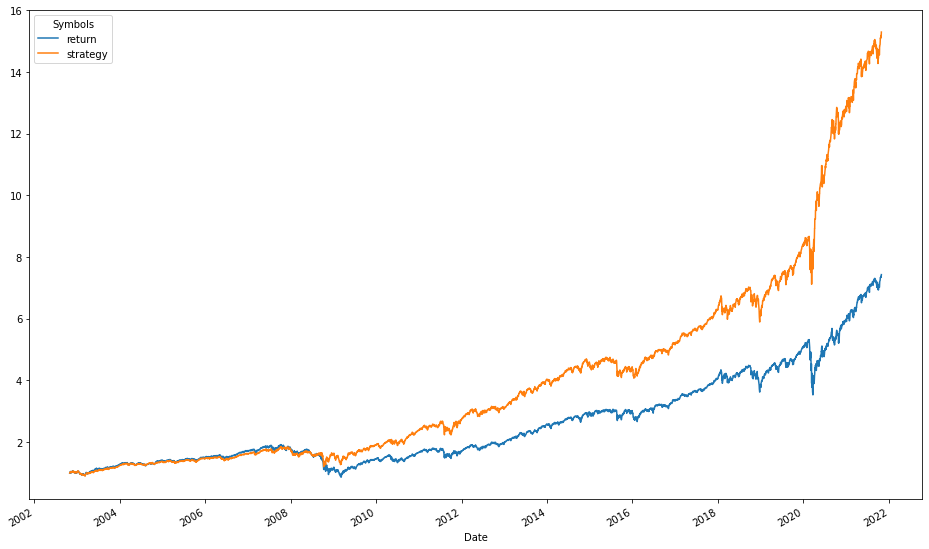

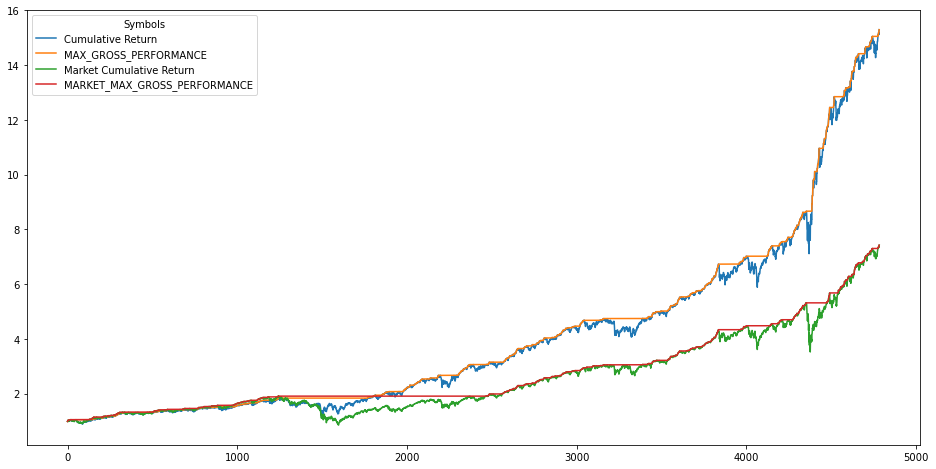

In [9]:
initial_capital= 500000
Deep_Neural(1,'2001-11-28','2002-10-31',LinearRegression())

### Machine Learning - K Neighbors Regressor

KNeighborsRegressor
Symbols
Cumulative Return (S&P500)      7.503679
Cumulative Return (Strategy)    8.190433
Name: 2021-10-29 00:00:00, dtype: float64

Sharpe Ratio (S&P500): 0.5603585860066694
Sharpe Ratio (Strategy): 0.7704817894949391
-478229.3167114258

Maximum Drawdown (S&P500): 1.7936012453483259
Maximum Drawdown (Strategy): 0.7639101461995699
Maximum Drawdown (S&P500) by pct of portfolio (%): 55.18944881701117
Maximum Drawdown (Strategy) by pct of portfolio (%): 22.35572805007963
Maximum Drawdown period (S&P500): 1773 days, 0:00:00
Maximum Drawdown (Strategy) period: 783 days, 0:00:00

Compound Annual Growth Rate(S&P500): 0.1118524249486188
Compound Annual Growth Rate(Strategy): 0.11638583795464208
Alpha(Strategy): 0.004533413006023279

Final amount after 19 years if invest $500k in Strategy ($): 2778589.683532715
Final amount after 19 years if invest $500k in SPY ($): 3713662.7500237045


/Users/User2/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


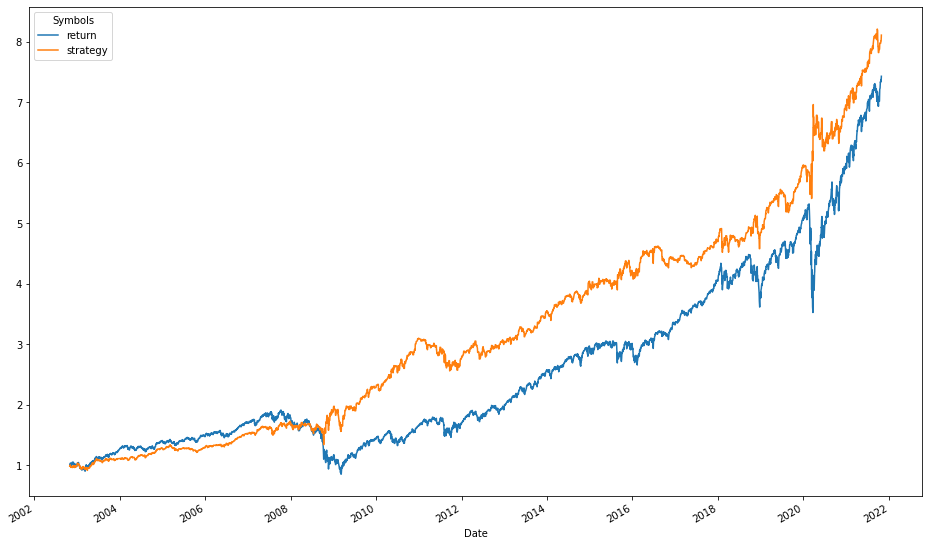

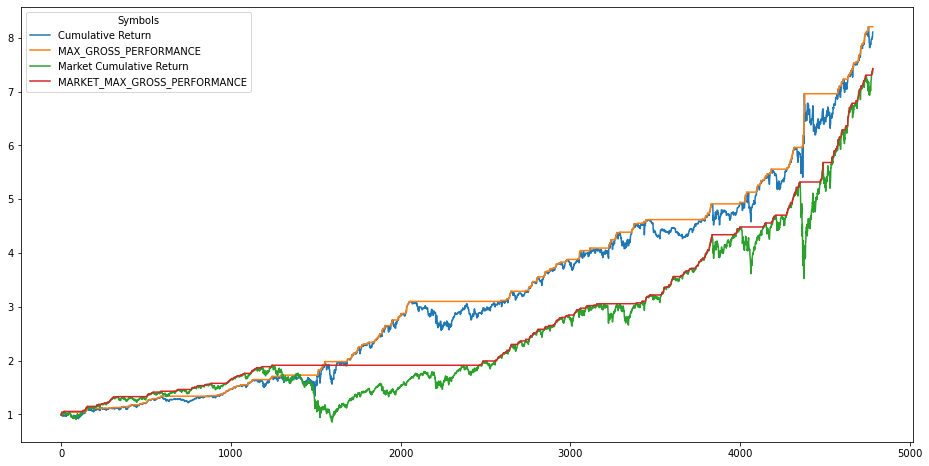

In [10]:
Deep_Neural(38,'2002-10-31','2002-10-31',KNeighborsRegressor())

### Machine Learning - SVR

SVR
Symbols
Cumulative Return (S&P500)       7.503679
Cumulative Return (Strategy)    11.647793
Name: 2021-10-29 00:00:00, dtype: float64

Sharpe Ratio (S&P500): 0.5603585860066694
Sharpe Ratio (Strategy): 0.7480848397278819
-378909.67559814453

Maximum Drawdown (S&P500): 1.7936012453483259
Maximum Drawdown (Strategy): 0.9923889375613468
Maximum Drawdown (S&P500) by pct of portfolio (%): 55.18944881701117
Maximum Drawdown (Strategy) by pct of portfolio (%): 40.94777832302319
Maximum Drawdown period (S&P500): 1773 days, 0:00:00
Maximum Drawdown (Strategy) period: 1092 days, 0:00:00

Compound Annual Growth Rate(S&P500): 0.1118524249486188
Compound Annual Growth Rate(Strategy): 0.1372609915789662
Alpha(Strategy): 0.025408566630347407

Final amount after 19 years if invest $500k in Strategy ($): 2824585.594177246
Final amount after 19 years if invest $500k in SPY ($): 3713662.7500237045


/Users/User2/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


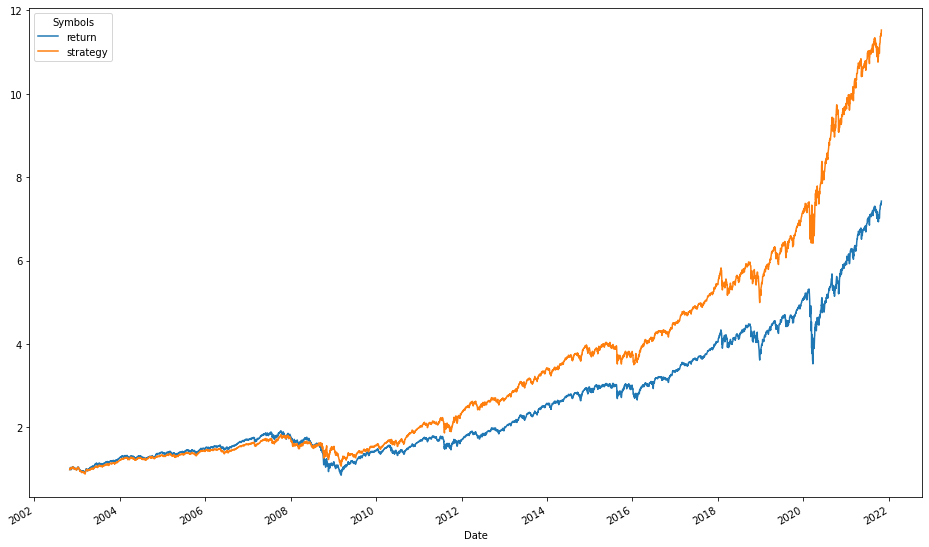

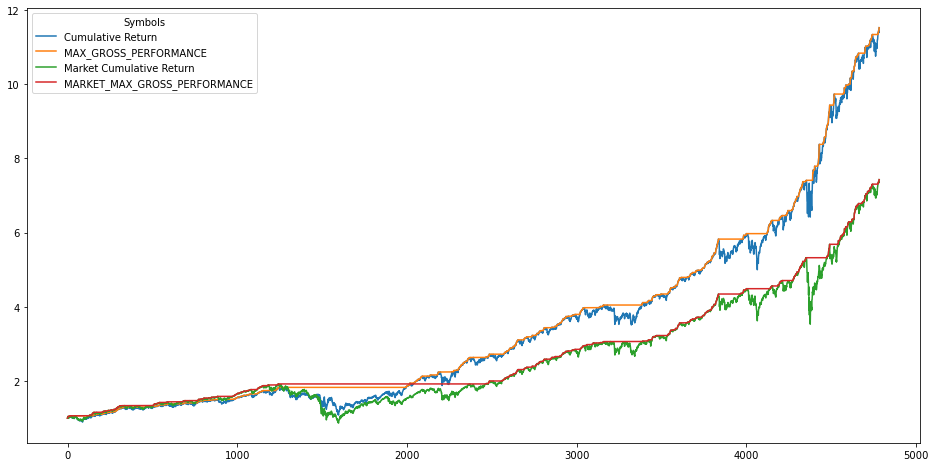

In [11]:
Deep_Neural(1,'2002-03-26','2002-10-31',SVR())

### Machine Learning - Extra Trees Regressor

ExtraTreesRegressor
Symbols
Cumulative Return (S&P500)      7.503679
Cumulative Return (Strategy)    7.475104
Name: 2021-10-29 00:00:00, dtype: float64

Sharpe Ratio (S&P500): 0.5603585860066694
Sharpe Ratio (Strategy): 0.7328895211483217
-1418632.2937011719

Maximum Drawdown (S&P500): 1.7936012453483259
Maximum Drawdown (Strategy): 0.911708730989087
Maximum Drawdown (S&P500) by pct of portfolio (%): 55.18944881701117
Maximum Drawdown (Strategy) by pct of portfolio (%): 24.235028434811355
Maximum Drawdown period (S&P500): 1773 days, 0:00:00
Maximum Drawdown (Strategy) period: 680 days, 0:00:00

Compound Annual Growth Rate(S&P500): 0.1118524249486188
Compound Annual Growth Rate(Strategy): 0.11103129985777715
Alpha(Strategy): -0.0008211250908416456

Final amount after 19 years if invest $500k in Strategy ($): 1784862.9760742188
Final amount after 19 years if invest $500k in SPY ($): 3713662.7500237045


/Users/User2/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


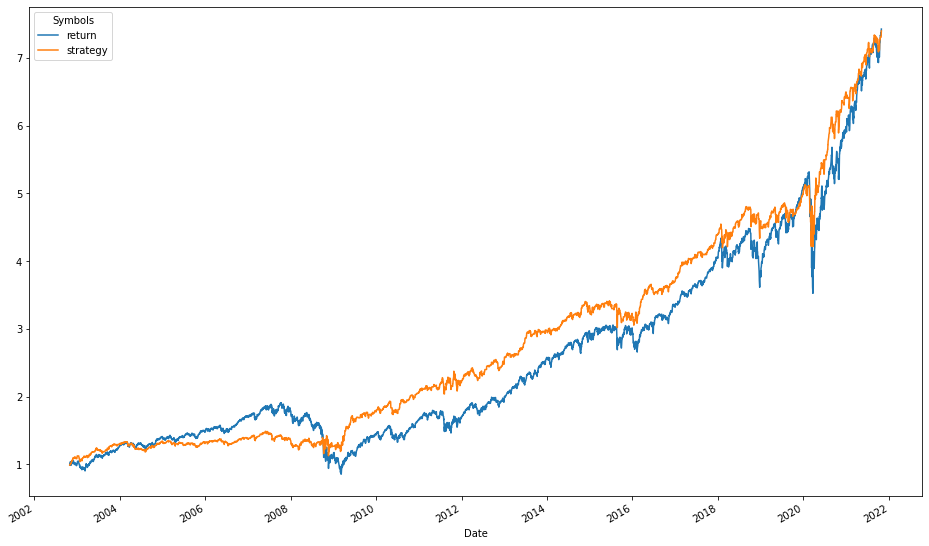

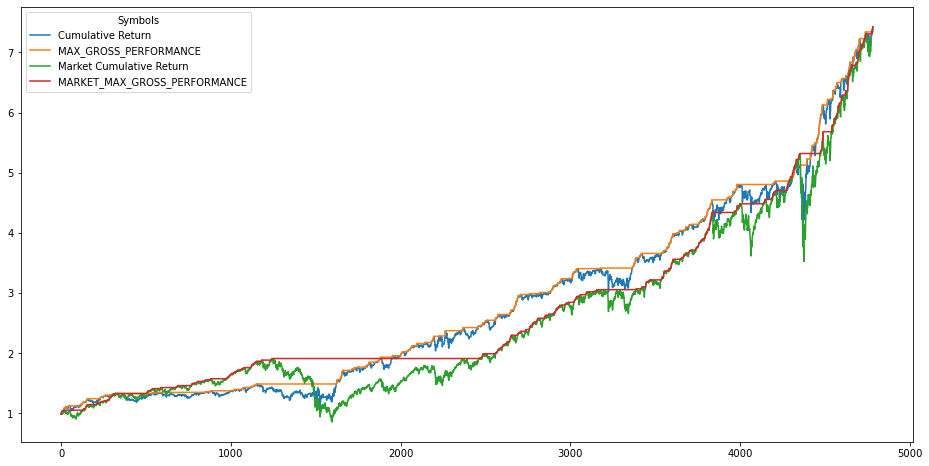

In [12]:
Deep_Neural(17,'2002-10-31','2002-10-31',ExtraTreesRegressor())

### Machine Learning - Random Forest Regressor

RandomForestRegressor
Symbols
Cumulative Return (S&P500)       7.503679
Cumulative Return (Strategy)    11.837260
Name: 2021-10-29 00:00:00, dtype: float64

Sharpe Ratio (S&P500): 0.5603585860066694
Sharpe Ratio (Strategy): 0.9395073319006277
-1145048.4619140625

Maximum Drawdown (S&P500): 1.7936012453483259
Maximum Drawdown (Strategy): 0.7472076070839577
Maximum Drawdown (S&P500) by pct of portfolio (%): 55.18944881701117
Maximum Drawdown (Strategy) by pct of portfolio (%): 27.73433097796855
Maximum Drawdown period (S&P500): 1773 days, 0:00:00
Maximum Drawdown (Strategy) period: 517 days, 0:00:00

Compound Annual Growth Rate(S&P500): 0.1118524249486188
Compound Annual Growth Rate(Strategy): 0.13822678218428486
Alpha(Strategy): 0.026374357235666057

Final amount after 19 years if invest $500k in Strategy ($): 2058446.8078613281
Final amount after 19 years if invest $500k in SPY ($): 3713662.7500237045


/Users/User2/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


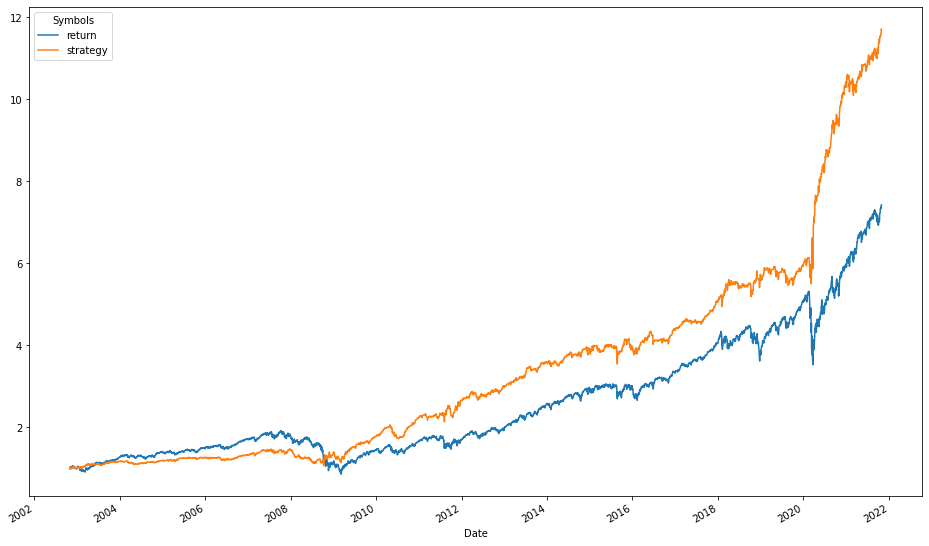

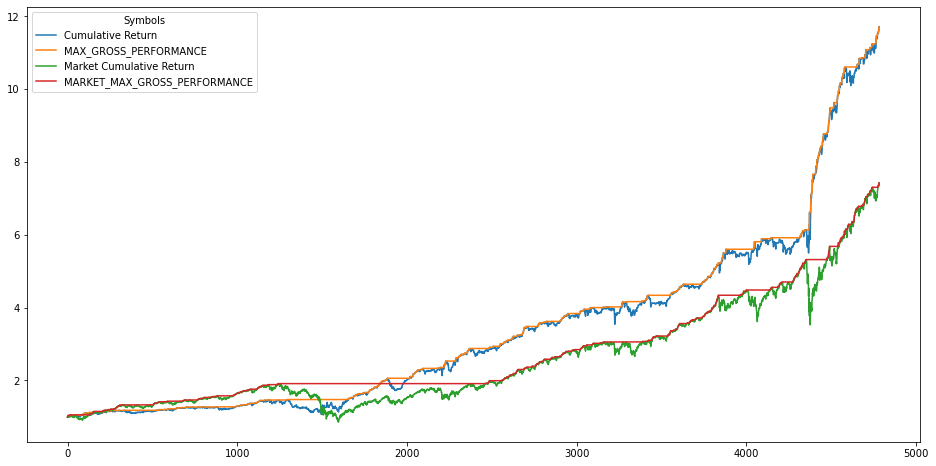

In [13]:
Deep_Neural(39,'2002-10-31','2002-10-31',RandomForestRegressor())

### Machine Learning - Gradient Boosting Regressor

GradientBoostingRegressor
Symbols
Cumulative Return (S&P500)      7.503679
Cumulative Return (Strategy)    8.687031
Name: 2021-10-29 00:00:00, dtype: float64

Sharpe Ratio (S&P500): 0.5603585860066694
Sharpe Ratio (Strategy): 0.7083951781545644
-1164058.7539672852

Maximum Drawdown (S&P500): 1.7936012453483259
Maximum Drawdown (Strategy): 0.7584780509709281
Maximum Drawdown (S&P500) by pct of portfolio (%): 55.18944881701117
Maximum Drawdown (Strategy) by pct of portfolio (%): 31.70071041682926
Maximum Drawdown period (S&P500): 1773 days, 0:00:00
Maximum Drawdown (Strategy) period: 661 days, 0:00:00

Compound Annual Growth Rate(S&P500): 0.1118524249486188
Compound Annual Growth Rate(Strategy): 0.11984840862116353
Alpha(Strategy): 0.007995983672544726

Final amount after 19 years if invest $500k in Strategy ($): 2039436.5158081055
Final amount after 19 years if invest $500k in SPY ($): 3713662.7500237045


/Users/User2/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


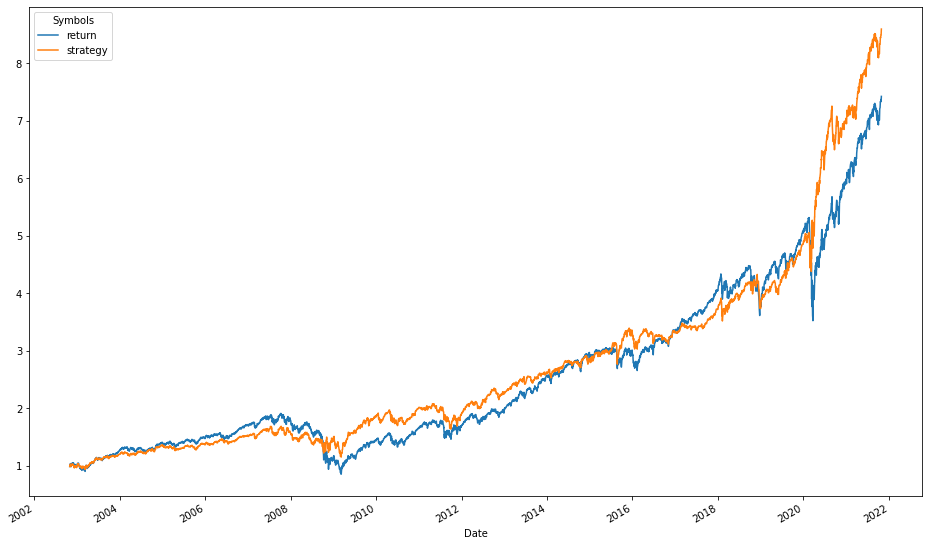

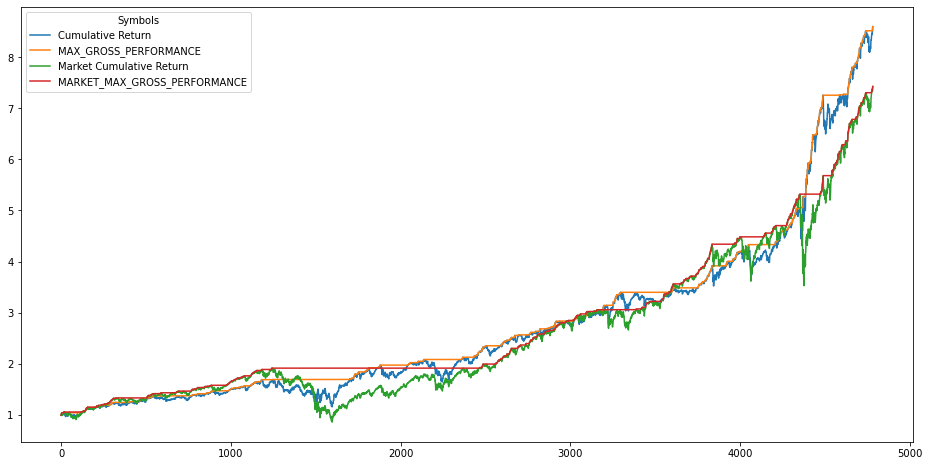

In [14]:
Deep_Neural(1,'1999-05-15','2002-10-31',GradientBoostingRegressor())

### Machine Learning - Ada Boost Regressor

AdaBoostRegressor
Symbols
Cumulative Return (S&P500)       7.503679
Cumulative Return (Strategy)    12.417346
Name: 2021-10-29 00:00:00, dtype: float64

Sharpe Ratio (S&P500): 0.5603585860066694
Sharpe Ratio (Strategy): 0.7435893196807706
-146917.58728027344


/Users/User2/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)



Maximum Drawdown (S&P500): 1.7936012453483259
Maximum Drawdown (Strategy): 1.074966750331698
Maximum Drawdown (S&P500) by pct of portfolio (%): 55.18944881701117
Maximum Drawdown (Strategy) by pct of portfolio (%): 47.957574649379104
Maximum Drawdown period (S&P500): 1773 days, 0:00:00
Maximum Drawdown (Strategy) period: 1015 days, 0:00:00

Compound Annual Growth Rate(S&P500): 0.1118524249486188
Compound Annual Growth Rate(Strategy): 0.14109521857207175
Alpha(Strategy): 0.029242793623452945

Final amount after 19 years if invest $500k in Strategy ($): 3343495.9106445312
Final amount after 19 years if invest $500k in SPY ($): 3713662.7500237045


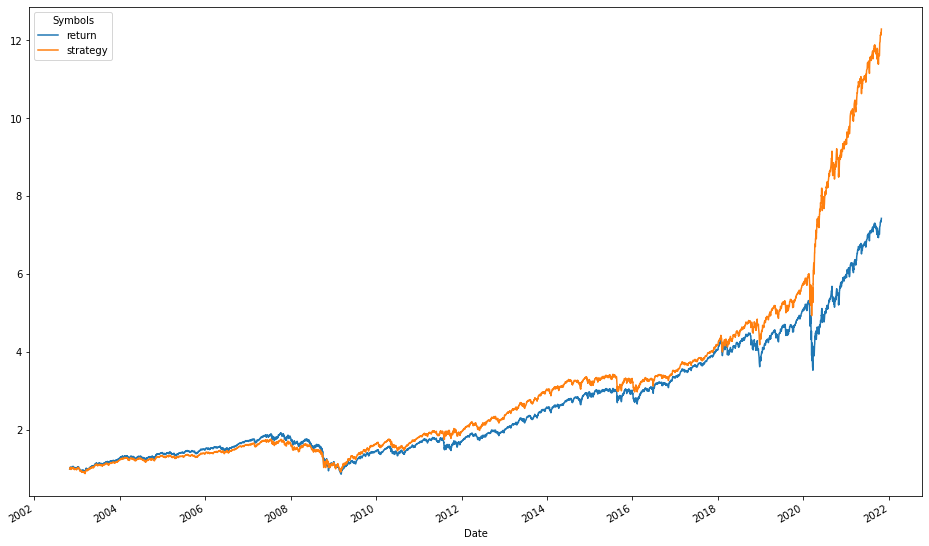

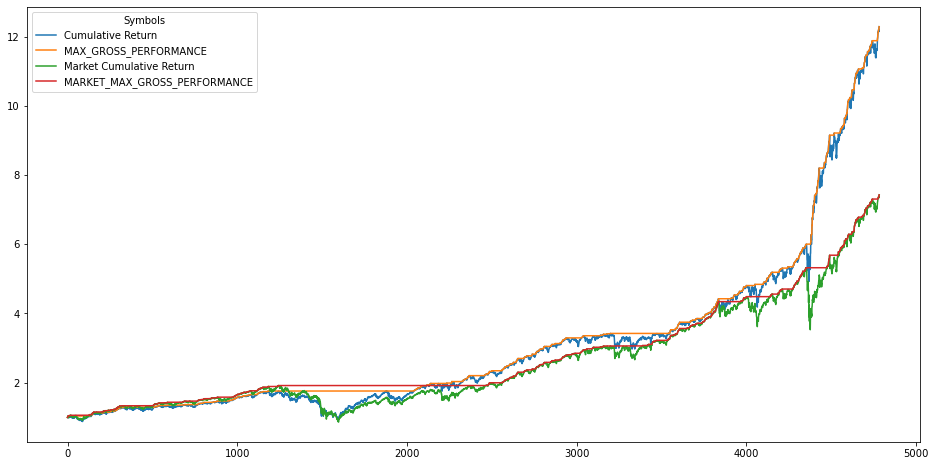

In [15]:
Deep_Neural(1,'1996-12-19','2002-10-31',AdaBoostRegressor())

### Machine Learning - MLP Regressor

MLPRegressor
Symbols
Cumulative Return (S&P500)       7.503679
Cumulative Return (Strategy)    16.468010
Name: 2021-10-29 00:00:00, dtype: float64

Sharpe Ratio (S&P500): 0.5603585860066694
Sharpe Ratio (Strategy): 0.8572728357118399
-318904.54864501953


/Users/User2/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)



Maximum Drawdown (S&P500): 1.7936012453483259
Maximum Drawdown (Strategy): 1.6373414349741457
Maximum Drawdown (S&P500) by pct of portfolio (%): 55.18944881701117
Maximum Drawdown (Strategy) by pct of portfolio (%): 35.34109061929406
Maximum Drawdown period (S&P500): 1773 days, 0:00:00
Maximum Drawdown (Strategy) period: 602 days, 0:00:00

Compound Annual Growth Rate(S&P500): 0.1118524249486188
Compound Annual Growth Rate(Strategy): 0.15817017388794108
Alpha(Strategy): 0.04631774893932228

Final amount after 19 years if invest $500k in Strategy ($): 2886526.3595581055
Final amount after 19 years if invest $500k in SPY ($): 3713662.7500237045


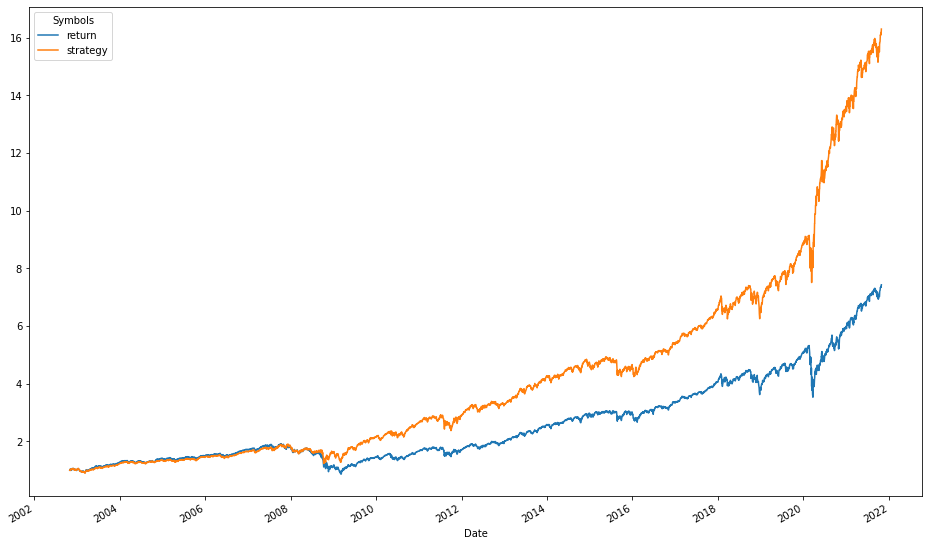

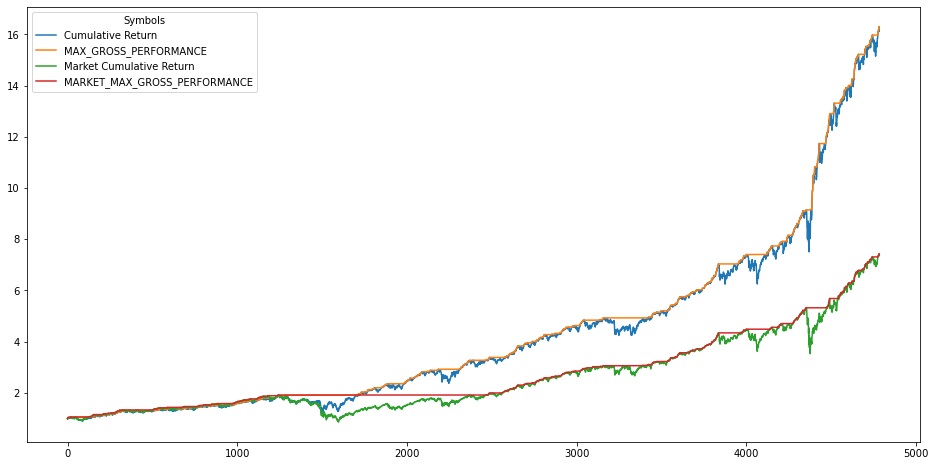

In [16]:
Deep_Neural(1,'1999-04-13','2002-10-31',MLPRegressor())

<a id="LGR"></a>
### Machine Learning - Logistics Regression

In [17]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

In [18]:
np.set_printoptions(precision = 3)

pd.set_option("precision", 3)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

In [19]:
%matplotlib inline

In [20]:
from sklearn import linear_model

In [21]:
data = pdr.get_data_yahoo("SPY", 
                          start = dt.datetime(1982,11,1),
                          end = dt.datetime(2021,10,31)
                         )

In [22]:
data_dl=data[['Adj Close']].copy()

In [23]:
data_dl.rename(columns = {'Adj Close':'Price'},inplace=True)

LogisticRegression(C=10000000.0, max_iter=100
Cumulative Return (S&P500)                 7.504
Cumulative Return (Logistic Regression)   13.357
Name: 2021-10-29 00:00:00, dtype: float64


<AxesSubplot:xlabel='Date'>

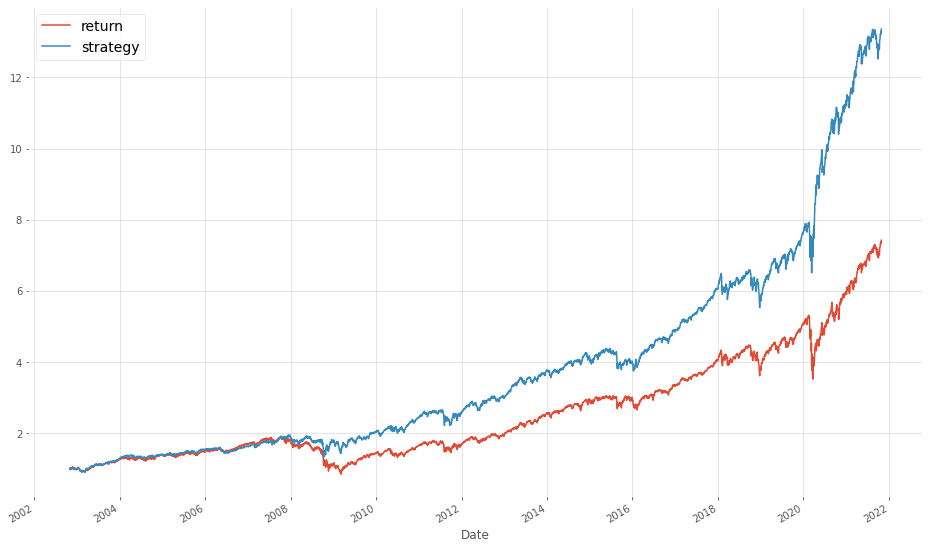

In [24]:
data_dl["return"] = np.log(data_dl["Price"] / data_dl["Price"].shift(1))
data_dl["direction"] = np.where(data_dl["return"] > 0, 1, 0)

lags=1
cols=[]

for lag in range(1,lags+1):
    col = f"lag_{lag}"
    data_dl[col] = data_dl["return"].shift(lag)
    cols.append(col)
data_dl.dropna(inplace = True)

model= linear_model.LogisticRegression(solver = "lbfgs",
                                    C = 1e7,
                                    multi_class = "auto",
                                    max_iter = 1000)
print(str(model)[:-2])

cutoff = "2002-10-31"

training_data = data_dl[data_dl.index < "2002-10-16"].copy()
testing_data = data_dl[data_dl.index >= cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std
testing_data_ = (testing_data - mu) / std

model.fit(training_data_[cols],
          training_data["direction"],
        )

predictions = np.where(model.predict(testing_data_[cols]) > 0.5,
                       1, 0)
testing_data["prediction"] = np.where(predictions > 0, 1, 0)
testing_data["strategy"] = (testing_data["prediction"] * testing_data["return"]
                         )
testing_data["Cumulative Return (S&P500)"] = testing_data[["return"]].cumsum().apply(np.exp)/testing_data[["return"]].cumsum().apply(np.exp).iloc[0]
testing_data["Cumulative Return (Logistic Regression)"] = testing_data[["strategy"]].cumsum().apply(np.exp)/testing_data[["strategy"]].cumsum().apply(np.exp).iloc[0]

print(testing_data[["Cumulative Return (S&P500)", "Cumulative Return (Logistic Regression)"]].iloc[-1])
testing_data[["return", "strategy"]].cumsum().apply(np.exp).plot(figsize = (16, 10))

In [25]:
Sharpe_ratio = np.sqrt(253) * testing_data["strategy"].mean() / testing_data["strategy"].std()
Sharpe_ratio

0.8235922692726447

Maximum Drawdown (Logistic Regression): 1.4201934833360292
Maximum Drawdown (Logistic Regression) by pct of portfolio (%): 31.908254049369283
Maximum Drawdown (Logistic Regression) period: 684 days, 0:00:00
Compound Annual Growth Rate(S&P500): 0.1118524249486188
Compound Annual Growth Rate(Logistic Regression): 0.14609956163062798
Alpha(Logistic Regression): 0.03424713668200918
Final capital if invest in Logistic Regression in our account ($): 6678537.137021997
Final capital if invest in S&P500 index in our account ($): 3713661.600444696


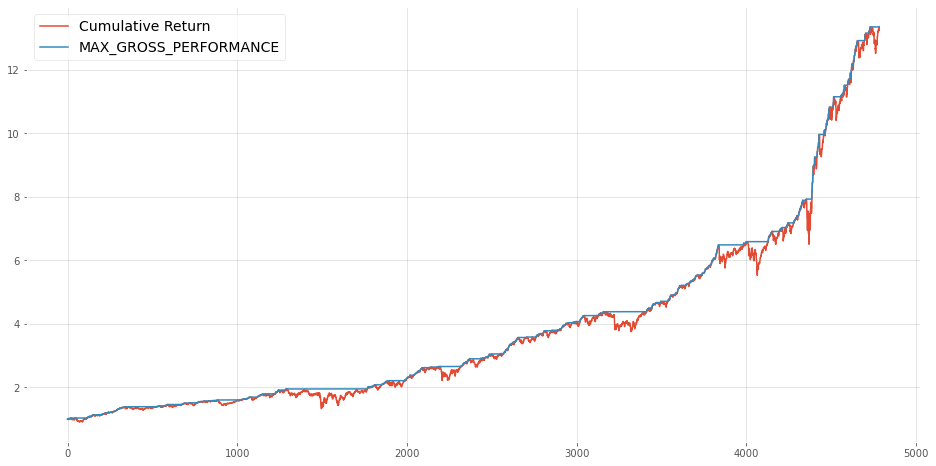

In [26]:
SPX500 = testing_data.copy()
SPX500 = SPX500.reset_index()
beginning_capital = 500000

SPX500.dropna(inplace=True)
SPX500['capital']=beginning_capital*SPX500['strategy'].cumsum().apply(np.exp)
SPX500['capital_index']=beginning_capital*SPX500['return'].cumsum().apply(np.exp)

SPX500['Cumulative Return']=SPX500['strategy'].cumsum().apply(np.exp)


SPX500['MAX_GROSS_PERFORMANCE']=SPX500['Cumulative Return'].cummax()
SPX500[['Cumulative Return','MAX_GROSS_PERFORMANCE']].dropna().plot(figsize=(16,8))
Drawdown=SPX500['MAX_GROSS_PERFORMANCE']-SPX500['Cumulative Return']
Drawdown_pct=(SPX500['MAX_GROSS_PERFORMANCE']-SPX500['Cumulative Return'])/SPX500['MAX_GROSS_PERFORMANCE']*100


Drawdown.index=SPX500.Date
PERIOD = (Drawdown[Drawdown == 0].index[1:].to_pydatetime() - 
          Drawdown[Drawdown == 0].index[:-1].to_pydatetime()
          )

D=(SPX500['Date'].iloc[-1]-SPX500['Date'].iloc[0]).days
CAGR_market=((SPX500['Price'].iloc[-1]/SPX500['Price'].iloc[0])**(365/D)-1)
CAGR_strategy =((SPX500['Cumulative Return'].iloc[-1])**(365/D)-1)
Alpha = CAGR_strategy - CAGR_market

print(f'Maximum Drawdown (Logistic Regression): {Drawdown.max()}')
print(f'Maximum Drawdown (Logistic Regression) by pct of portfolio (%): {Drawdown_pct.max()}')
print(f'Maximum Drawdown (Logistic Regression) period: {PERIOD.max()}')
print(f'Compound Annual Growth Rate(S&P500): {CAGR_market}')
print(f'Compound Annual Growth Rate(Logistic Regression): {CAGR_strategy}')
print(f'Alpha(Logistic Regression): {Alpha}')
print('Final capital if invest in Logistic Regression in our account ($): {}'.format(SPX500['capital'].iloc[-1]))
print('Final capital if invest in S&P500 index in our account ($): {}'.format(SPX500['capital_index'].iloc[-1]))